In [ ]:
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as shc
from scipy.io import loadmat
from time import time
#import umap

from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_samples, silhouette_score
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, completeness_score, homogeneity_score, mutual_info_score, rand_score, v_measure_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = loadmat('/content/drive/MyDrive/Indian_pines_corrected.mat')
ground_truth = loadmat('/content/drive/MyDrive/Indian_pines_gt.mat')

data_array = np.array(data['indian_pines_corrected'])
gt = ground_truth['indian_pines_gt']

#plt.imshow(gt, interpolation='nearest')
#plt.title('Ground Truth')
#plt.axis('off')
#plt.show()

In [ ]:
# visualisation
# read and enhance
def plot_array_stretched(array, label, n):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    plt.axis('off')
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    cb = plt.imshow(array, cmap='Greys_r', vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    plt.colorbar(cb, shrink=1, label=label)
    plt.show()

@interact(band=range(1, data_array.shape[2]+1))
def show_dist(band):
    plot_array_stretched(data_array[:, :, band-1], f'Band {band}', 2)

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

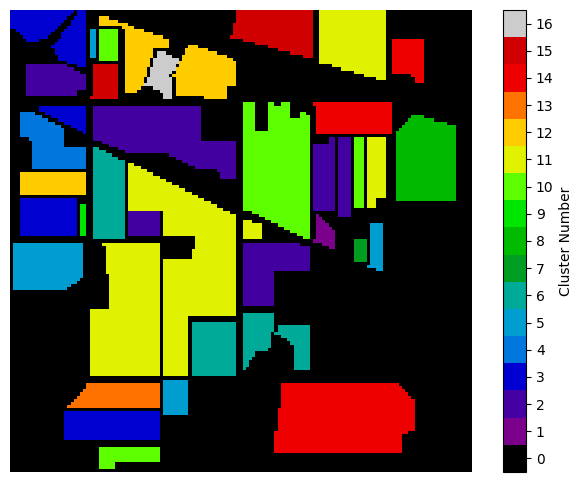

In [ ]:
def plot_data(data, n_clusters):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    plt.axis('off')
    cmap = cm.get_cmap('nipy_spectral', n_clusters)
    plt.imshow(data, cmap=cmap)
    cbar = plt.colorbar(label='Cluster Number')
    tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(np.arange(n_clusters))
    
    plt.show()

plot_data(gt, 17)

In [ ]:
# Reshape the input data from rcb to samples and features
data_reshaped = data_array.reshape(data_array.shape[0]*data_array.shape[1], -1)
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)
gt_reshaped = gt.flatten()

In [ ]:
# PCA
pca = PCA(random_state=1)
components = pca.fit_transform(data_reshaped)
eigenvalues = pca.explained_variance_
var_ratio = pca.explained_variance_ratio_

var_sum = 0
for i in range(len(var_ratio)):
    if var_sum >= 0.9:
        break
    else:
        var_sum += var_ratio[i]

selected_components = components[:, :i]
print('Number of spectral bands:', data_reshaped.shape[1])
print(f'Number of selected principal components: {i}')

Number of spectral bands: 200
Number of selected principal components: 2


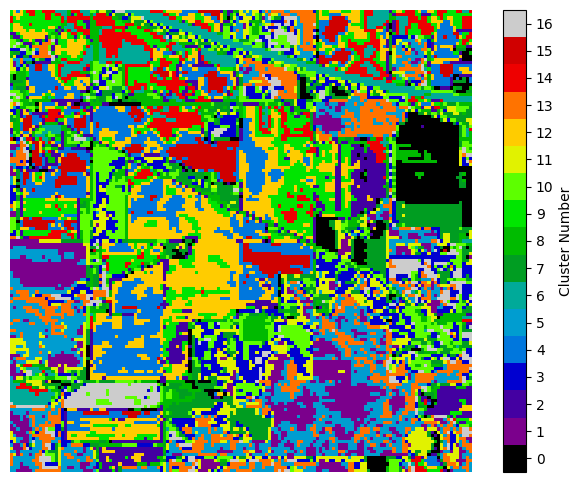

In [ ]:
# k-means clustering using the components generated in the previous cell
# init, n_init, max_iter, algorithm
k_means = cluster.KMeans(n_clusters=17, random_state=1) # create an object of the classifier
labels = k_means.fit_predict(selected_components) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

In [ ]:
pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.6 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from numpy import mean
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args

In [ ]:
# n_clusters = 16

search_space = { "init" : Categorical(['k-means++']),      # 'random'
                "n_init" : Integer(1, 50),
                "max_iter" : Integer(100, 500),
                "algorithm" : Categorical(['elkan']),     # 'lloyd'

}


kmeans_cl = cluster.KMeans(n_clusters = 16, random_state = 1)


In [ ]:
kmeans_bayes_search = BayesSearchCV(kmeans_cl, search_space, n_iter=32, # specify how many iterations
                                    scoring="v_measure_score", n_jobs=-1, cv=5)


#def on_step(optim_result):

  #score = kmeans_bayes_search.best_score_
  #print("best score: %s" % score)
  #if score >= 0.98:
    #print('Interrupting!')
    #return True


kmeans_bayes_search.fit(selected_components, gt_reshaped)

BayesSearchCV(cv=5, estimator=KMeans(n_clusters=16, random_state=1), n_iter=32,
              n_jobs=-1, scoring='v_measure_score',
              search_spaces={'algorithm': Categorical(categories=('lloyd',), prior=None),
                             'init': Categorical(categories=('k-means++',), prior=None),
                             'max_iter': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                             'n_init': Integer(low=1, high=50, prior='uniform', transform='normalize')})

In [ ]:
kmeans_bayes_search.best_params_

OrderedDict([('algorithm', 'lloyd'),
             ('init', 'k-means++'),
             ('max_iter', 500),
             ('n_init', 9)])

In [ ]:
kmeans_bayes_search.best_estimator_

KMeans(max_iter=500, n_clusters=16, n_init=9, random_state=1)

In [ ]:
kmeans_bayes_search.best_score_

0.31885606181705245

**MINI-BATCH**

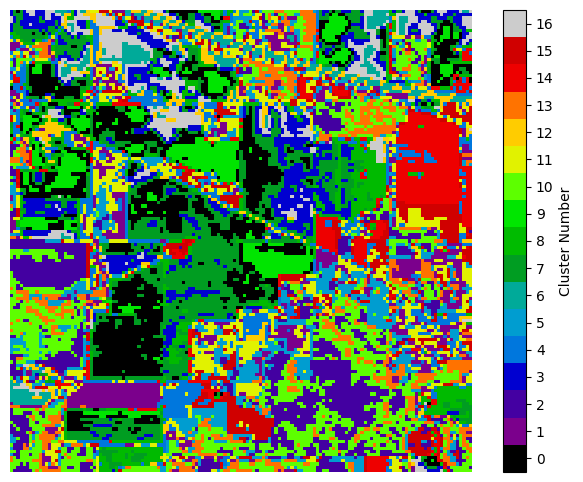

In [ ]:
# minibatch k-means clustering using the principal components
# init, batch_size, max_iter, max_no_improvement, reassignment_ratio, n_init
minibatch_kmeans = cluster.MiniBatchKMeans(n_clusters=17, random_state=1) # create an object of the classifier
labels = minibatch_kmeans.fit_predict(selected_components) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

In [ ]:
# n_clusters = 16

search_space = { "init" : Categorical(['random']),    # 'k-means++'
                "n_init" : Integer(1, 10),
                "max_iter" : Integer(100, 500),
                "batch_size" : Integer(256, 1024),
                "max_no_improvement" : Integer(0, 20),
                #"reassignment_ratio" : Integer(0.001, 1),
                
}

mbkmeans_cl = cluster.MiniBatchKMeans(n_clusters = 16, random_state = 1)

mbkmeans_bayes_search = BayesSearchCV(mbkmeans_cl, search_space, n_iter=32, # specify how many iterations
                                    scoring="v_measure_score", n_jobs=-1, cv=5)

#def on_step(optim_result):

  #score = kmeans_bayes_search.best_score_
  #print("best score: %s" % score)
  #if score >= 0.98:
    #print('Interrupting!')
    #return True


mbkmeans_bayes_search.fit(selected_components, gt_reshaped)

BayesSearchCV(cv=5, estimator=MiniBatchKMeans(n_clusters=16, random_state=1),
              n_iter=32, n_jobs=-1, scoring='v_measure_score',
              search_spaces={'batch_size': Integer(low=256, high=1024, prior='uniform', transform='normalize'),
                             'init': Categorical(categories=('random',), prior=None),
                             'max_iter': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                             'max_no_improvement': Integer(low=0, high=20, prior='uniform', transform='normalize'),
                             'n_init': Integer(low=1, high=10, prior='uniform', transform='normalize')})

In [ ]:
mbkmeans_bayes_search.best_params_

OrderedDict([('batch_size', 822),
             ('init', 'random'),
             ('max_iter', 180),
             ('max_no_improvement', 1),
             ('n_init', 7)])

In [ ]:
mbkmeans_bayes_search.best_score_

0.32802247296451337

**BISECTING KMEANS**

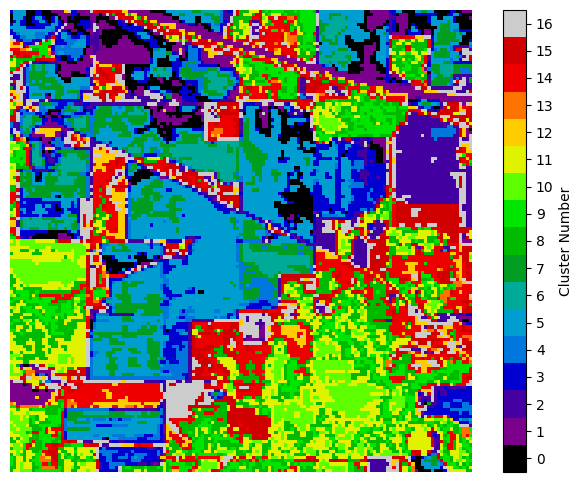

In [ ]:
# bisecting k-means clustering using the principal components
# init, n_init, max_iter, bisecting_strategy, algorithm
bisecting_kmeans = cluster.BisectingKMeans(n_clusters=17, random_state=1) # create an object of the classifier
labels = bisecting_kmeans.fit_predict(selected_components) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

In [ ]:
# n_clusters = 16

search_space = { "init" : Categorical(['k-means++']),  # 'random'
                "n_init" : Integer(1, 10),
                "max_iter" : Integer(100, 500),
                "algorithm" : Categorical(['elkan']), # 'lloyd'
                "bisecting_strategy" : Categorical(['biggest_inertia', 'largest_cluster']),

}

bskmeans_cl = cluster.BisectingKMeans(n_clusters = 16, random_state = 1)

bskmeans_bayes_search = BayesSearchCV(bskmeans_cl, search_space, n_iter=32, # specify how many iterations
                                    scoring="v_measure_score", n_jobs=-1, cv=5)

#def on_step(optim_result):

  #score = bskmeans_bayes_search.best_score_
  #print("best score: %s" % score)
  #if score >= 0.98:
    #print('Interrupting!')
    #return True


bskmeans_bayes_search.fit(selected_components, gt_reshaped)

BayesSearchCV(cv=5, estimator=BisectingKMeans(n_clusters=16, random_state=1),
              n_iter=32, n_jobs=-1, scoring='v_measure_score',
              search_spaces={'algorithm': Categorical(categories=('elkan',), prior=None),
                             'bisecting_strategy': Categorical(categories=('biggest_inertia', 'largest_cluster'), prior=None),
                             'init': Categorical(categories=('k-means++',), prior=None),
                             'max_iter': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                             'n_init': Integer(low=1, high=10, prior='uniform', transform='normalize')})

In [ ]:
bskmeans_bayes_search.best_params_

OrderedDict([('algorithm', 'elkan'),
             ('bisecting_strategy', 'biggest_inertia'),
             ('init', 'k-means++'),
             ('max_iter', 148),
             ('n_init', 1)])

In [ ]:
bskmeans_bayes_search.best_score_

0.3033611899624614

**BIRCH**

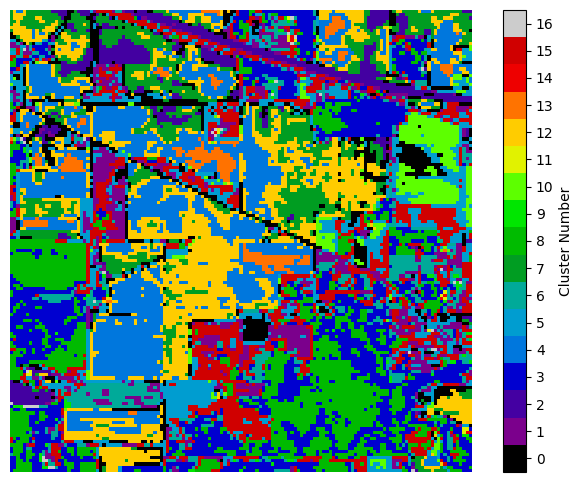

In [ ]:
# birch clustering using the components generated in the previous cell
# threshold, branching_factor
birch = cluster.Birch(n_clusters=17) # create an object of the classifier
labels = birch.fit_predict(selected_components) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

In [ ]:
# n_clusters = 16

search_space = { "threshold" : Integer[np.linspace(0.0, 2.0, num = 0.1)],
                "branching_factor" : Integer(10, 100),

}

birch_cl = cluster.Birch(n_clusters = 16)

birch_bayes_search = BayesSearchCV(birch_cl, search_space, n_iter=32, # specify how many iterations
                                    scoring="v_measure_score", n_jobs=-1, cv=5)


birch_bayes_search.fit(selected_components, gt_reshaped)

TypeError: ignored

In [ ]:
# n_clusters = 16

search_space = { #"threshold" : Integer([0.1, 1]),
                "branching_factor" : Integer(10, 100),

}

birch_cl = cluster.Birch(n_clusters = 16)

birch_bayes_search = BayesSearchCV(birch_cl, search_space, n_iter=32, # specify how many iterations
                                    scoring="v_measure_score", n_jobs=-1, cv=5)

#def on_step(optim_result):

  #score = birch_bayes_search.best_score_
  #print("best score: %s" % score)
  #if score >= 0.98:
    #print('Interrupting!')
    #return True


birch_bayes_search.fit(selected_components, gt_reshaped)

BayesSearchCV(cv=5, estimator=Birch(n_clusters=16), n_iter=32, n_jobs=-1,
              scoring='v_measure_score',
              search_spaces={'branching_factor': Integer(low=10, high=100, prior='uniform', transform='normalize')})

In [ ]:
birch_bayes_search.best_params_

OrderedDict([('branching_factor', 21)])

In [ ]:
birch_bayes_search.best_score_

0.3304566608087328

**SPECTRAL CLUSTERING**

In [ ]:
# spectral clustering using the components generated in the previous cell
# eigen_solver, affinity, degree, n_init
spectral = cluster.SpectralClustering(n_clusters=17, random_state=1, n_jobs=-1) # create an object of the classifier
labels = spectral.fit_predict(selected_components) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

In [ ]:
# n_clusters = 16

search_space = { "eigen_solver" : Categorical(['arpack', 'lobpcg', 'amg']),
                "n_init" : Integer(1, 20),
                "max_iter" : Integer(100, 500),
                "algorithm" : Categorical(['lloyd', 'elkan']),

}

kmeans_cl = cluster.KMeans(n_clusters = 16, random_state = 1)

kmeans_bayes_search = BayesSearchCV(kmeans_cl, search_space, n_iter=32, # specify how many iterations
                                    scoring="v_measure_score", n_jobs=-1, cv=5)

#def on_step(optim_result):

  #score = kmeans_bayes_search.best_score_
  #print("best score: %s" % score)
  #if score >= 0.98:
    #print('Interrupting!')
    #return True


kmeans_bayes_search.fit(selected_components, gt_reshaped)

**AGGLOMERATIVE CLUSTERING**

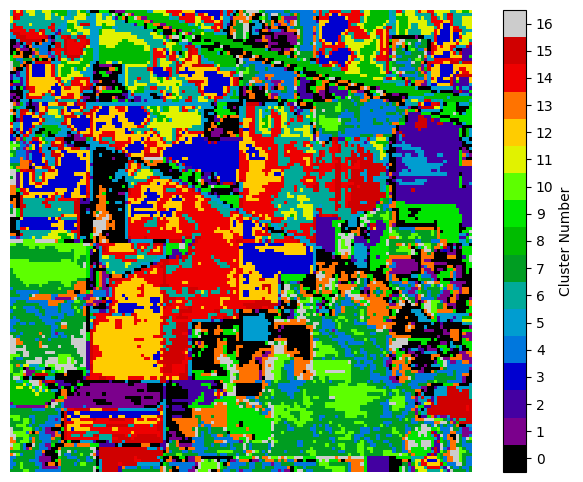

In [ ]:
# agglomerative clustering using the components generated in the previous cell
# affinity, linkage
agglomerative = cluster.AgglomerativeClustering(n_clusters=17) # create an object of the classifier
labels = agglomerative.fit_predict(selected_components) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

class AgglomerativeClusteringWrapper(AgglomerativeClustering):
    def predict(self,X):
      return self.labels_.astype(int)

In [ ]:
# n_clusters = 16

search_space = { "metric" : Categorical(['euclidean', 'l1', 'l2', 'cosine', 'precomputed']), #'affinity' parameter was discontinued, 'metric' parameter is used instead. 
                "linkage" : Categorical(['ward', 'complete', 'average', 'single']),

}

agglom_cl = cluster.AgglomerativeClustering(n_clusters = 16)

agglom_bayes_search = BayesSearchCV(agglom_cl, search_space, n_iter=32, # specify how many iterations
                                    scoring="v_measure_score", n_jobs=-1, cv=5)


agglom_bayes_search.fit(selected_components, gt_reshaped)

AttributeError: ignored